# Model Evaluation
The following notebook generates the corresponding results in shown in Tables 1 and 2, as per our analysis from the paper. The results shown here are reproducible with respect to the fixed seed value we have fixed for our pseudo-random sampling methods.

In [1]:
import math
import random
import warnings
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import matthews_corrcoef, accuracy_score

# Supress All Warnings
warnings.filterwarnings('ignore')

In [2]:
# Application Hyperparameters
DATA_ROOT = '../data/out/data3.fasta.txt/'
SERVERS = ['ADAM_HMM', 'ADAM_SVM', 'AMPA', 'CMPR3_ANN', 'CMPR3_DA', 'CMPR3_RF', 'CMPR3_SVM', 'DBAASP']
DATASET = ['A', 'D']
REVERSE = ['', 'R', 'R1', 'R2', 'R3']
SEED = 9892 # SEED for PRNG

# Initialize PRNG
random.seed(SEED)

# Helper Function for Display
def data_type(d, r):
    d_type = 'APD' if d == 'A' else 'DAMPD'
    if r == '': r_type = 'BAL'
    elif r[0] == 'R': 
        r_type = 'RAND' + str(r[1]) if len(r) > 1 else 'REV'
    return d_type, r_type

## Load Dataset
We first load our dataset from the processed CSV files, which are contained under the data3 folder. We note that during this process, we only load the positive samples for the balanced set - hence the total number of samples shown below are only half of the original sample counts.

In [3]:
data = {}
for s in SERVERS:
    raw = pd.read_csv(DATA_ROOT + s + '.csv')
    data[s] = {}
    for d in DATASET:
        data[s][d] = {}
        for r in REVERSE:
            # Append True Values
            data[s][d][r] = pd.DataFrame(raw[raw.PepID.str.contains(d)][raw.PepID.str.contains('R') == False][raw.AMPLabel == 1])
            
            # Filter Operations by Type
            if r == 'R':
                data[s][d][r] = data[s][d][r].append(raw[raw.PepID.str.contains(d)][raw.PepID.str.contains('R') == True][raw.PepID.str.contains('R1') == False][raw.PepID.str.contains('R2') == False][raw.PepID.str.contains('R3') == False])
            elif r != '':
                data[s][d][r] = data[s][d][r].append(raw[raw.PepID.str.contains(d)][raw.PepID.str.contains(r)])       
            
            d_type, r_type = data_type(d, r)
            print(s + ' ['+d_type+'_'+r_type+']' + ' : ' + str(data[s][d][r].shape[0]) + ' RECORDS')
        print('-'*30)

ADAM_HMM [APD_BAL] : 1713 RECORDS
ADAM_HMM [APD_REV] : 3426 RECORDS
ADAM_HMM [APD_RAND1] : 3426 RECORDS
ADAM_HMM [APD_RAND2] : 3426 RECORDS
ADAM_HMM [APD_RAND3] : 3426 RECORDS
------------------------------
ADAM_HMM [DAMPD_BAL] : 547 RECORDS
ADAM_HMM [DAMPD_REV] : 1094 RECORDS
ADAM_HMM [DAMPD_RAND1] : 1094 RECORDS
ADAM_HMM [DAMPD_RAND2] : 1094 RECORDS
ADAM_HMM [DAMPD_RAND3] : 1094 RECORDS
------------------------------
ADAM_SVM [APD_BAL] : 1713 RECORDS
ADAM_SVM [APD_REV] : 3426 RECORDS
ADAM_SVM [APD_RAND1] : 3426 RECORDS
ADAM_SVM [APD_RAND2] : 3426 RECORDS
ADAM_SVM [APD_RAND3] : 3426 RECORDS
------------------------------
ADAM_SVM [DAMPD_BAL] : 547 RECORDS
ADAM_SVM [DAMPD_REV] : 1094 RECORDS
ADAM_SVM [DAMPD_RAND1] : 1094 RECORDS
ADAM_SVM [DAMPD_RAND2] : 1094 RECORDS
ADAM_SVM [DAMPD_RAND3] : 1094 RECORDS
------------------------------
AMPA [APD_BAL] : 1713 RECORDS
AMPA [APD_REV] : 3426 RECORDS
AMPA [APD_RAND1] : 3426 RECORDS
AMPA [APD_RAND2] : 3426 RECORDS
AMPA [APD_RAND3] : 3426 RECORD

### Original Dataset Rebalancing
We consider the rebalancing of our original dataset based on the random sampling of negative samples to match the sample size of the positive samples. Here we first determine the distribution of the positive samples and map them to a dictionary, then correspondingly randomly sample from the same index pool of the negative samples.

In [4]:
orig_dist = {}
for s in SERVERS:
    raw = pd.read_csv(DATA_ROOT + s + '.csv')
    orig_dist[s] = {}
    for d in DATASET:
        # Evaluate Sequence Length Positive Samples
        len_count = raw[raw.PepID.str.contains(d)][raw.PepID.str.contains('R') == False][raw.AMPLabel == 1]['PepSeq'].str.len()
        
        # Track Distribution from Positive Samples
        orig_dist[s][d] = {}
        for l in len_count:
            if l not in orig_dist[s][d]:
                orig_dist[s][d][l] = 0
            orig_dist[s][d][l] += 1

In [5]:
for s in SERVERS:
    raw = pd.read_csv(DATA_ROOT + s + '.csv')
    for d in DATASET:
        # Identify Negative Sequence Distribution
        dat = raw[raw.PepID.str.contains(d)][raw.PepID.str.contains('R') == False][raw.AMPLabel == 0]
        seq_len = dat['PepSeq'].astype(str).str.len()
        
        # Randomly Sample Based on Number of Positive Samples
        for k in list(orig_dist[s][d]):
            idx = seq_len[seq_len == k].index.values
            idx_sel = np.random.choice(len(idx), orig_dist[s][d][k], replace=False)
            
            data[s][d][''] = data[s][d][''].append(dat[dat.index.isin(idx[idx_sel])])

### Filtering Pre-Processing
In some of the given samples, we have encountered some data that are missing. This may be due to several of the following reasons:
1. The given sample's AMP sequence was not considered a valid one due to the rejection by the evaluation servers.
2. Some error occured due to server requests and was not able to be process - we have, however, attempted to minimize this as much as possible.

We have attempted to make the sample size roughly the same across all of the given samples.

In [6]:
# Filter -999 Values
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            pre_filter = data[s][d][r].shape[0]
            data[s][d][r] = data[s][d][r].query('PredLabel != -999')
            d_type, r_type = data_type(d, r)
            print(s + ' ['+d_type+'_'+r_type+']' + ' (POST-FILTERED): ' + str(data[s][d][r].shape[0]) + ' RECORDS ' + '('+ str(pre_filter - data[s][d][r].shape[0]) +' FILTERED)')
        print('-'*75)

ADAM_HMM [APD_BAL] (POST-FILTERED): 3426 RECORDS (0 FILTERED)
ADAM_HMM [APD_REV] (POST-FILTERED): 3426 RECORDS (0 FILTERED)
ADAM_HMM [APD_RAND1] (POST-FILTERED): 3426 RECORDS (0 FILTERED)
ADAM_HMM [APD_RAND2] (POST-FILTERED): 3426 RECORDS (0 FILTERED)
ADAM_HMM [APD_RAND3] (POST-FILTERED): 3426 RECORDS (0 FILTERED)
---------------------------------------------------------------------------
ADAM_HMM [DAMPD_BAL] (POST-FILTERED): 1076 RECORDS (18 FILTERED)
ADAM_HMM [DAMPD_REV] (POST-FILTERED): 1078 RECORDS (16 FILTERED)
ADAM_HMM [DAMPD_RAND1] (POST-FILTERED): 1078 RECORDS (16 FILTERED)
ADAM_HMM [DAMPD_RAND2] (POST-FILTERED): 1078 RECORDS (16 FILTERED)
ADAM_HMM [DAMPD_RAND3] (POST-FILTERED): 1078 RECORDS (16 FILTERED)
---------------------------------------------------------------------------
ADAM_SVM [APD_BAL] (POST-FILTERED): 3425 RECORDS (1 FILTERED)
ADAM_SVM [APD_REV] (POST-FILTERED): 3426 RECORDS (0 FILTERED)
ADAM_SVM [APD_RAND1] (POST-FILTERED): 3426 RECORDS (0 FILTERED)
ADAM_SVM [APD

## Threshold Based Metrics

### Confusion Matrix

In [7]:
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            d_type, r_type = data_type(d, r)
            print('[' + s + ' ['+d_type+'_'+r_type+']' + ']')
            con_mat = confusion_matrix(data[s][d][r]['AMPLabel'], data[s][d][r]['PredLabel'], labels=[1, 0])
            print(str(con_mat) + '\n')
            print('True Positive:\t' + str(con_mat[0][0]))
            print('False Positive:\t' + str(con_mat[0][1]))
            print('False Negative:\t' + str(con_mat[1][0]))
            print('True Negative:\t' + str(con_mat[1][1]))
            print('-'*40)
    print('='* 40)

[ADAM_HMM [APD_BAL]]
[[1558  155]
 [ 645 1068]]

True Positive:	1558
False Positive:	155
False Negative:	645
True Negative:	1068
----------------------------------------
[ADAM_HMM [APD_REV]]
[[1558  155]
 [ 792  921]]

True Positive:	1558
False Positive:	155
False Negative:	792
True Negative:	921
----------------------------------------
[ADAM_HMM [APD_RAND1]]
[[1558  155]
 [ 489 1224]]

True Positive:	1558
False Positive:	155
False Negative:	489
True Negative:	1224
----------------------------------------
[ADAM_HMM [APD_RAND2]]
[[1558  155]
 [ 547 1166]]

True Positive:	1558
False Positive:	155
False Negative:	547
True Negative:	1166
----------------------------------------
[ADAM_HMM [APD_RAND3]]
[[1558  155]
 [ 765  948]]

True Positive:	1558
False Positive:	155
False Negative:	765
True Negative:	948
----------------------------------------
[ADAM_HMM [DAMPD_BAL]]
[[417 114]
 [166 379]]

True Positive:	417
False Positive:	114
False Negative:	166
True Negative:	379
---------------------

In [8]:
print('Classification Report')

for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            d_type, r_type = data_type(d, r)
            print('['+s + ' ['+d_type+'_'+r_type+']'+']')
            print(classification_report(data[s][d][r]['AMPLabel'], data[s][d][r]['PredLabel'], [0, 1]))
            print('='*40)

Classification Report
[ADAM_HMM [APD_BAL]]
              precision    recall  f1-score   support

           0       0.87      0.62      0.73      1713
           1       0.71      0.91      0.80      1713

    accuracy                           0.77      3426
   macro avg       0.79      0.77      0.76      3426
weighted avg       0.79      0.77      0.76      3426

[ADAM_HMM [APD_REV]]
              precision    recall  f1-score   support

           0       0.86      0.54      0.66      1713
           1       0.66      0.91      0.77      1713

    accuracy                           0.72      3426
   macro avg       0.76      0.72      0.71      3426
weighted avg       0.76      0.72      0.71      3426

[ADAM_HMM [APD_RAND1]]
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1713
           1       0.76      0.91      0.83      1713

    accuracy                           0.81      3426
   macro avg       0.82      0.81      0.

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      1712
           1       0.85      0.95      0.90      1713

    accuracy                           0.89      3425
   macro avg       0.90      0.89      0.89      3425
weighted avg       0.90      0.89      0.89      3425

[CMPR3_RF [APD_REV]]
              precision    recall  f1-score   support

           0       0.61      0.08      0.15      1713
           1       0.51      0.95      0.66      1713

    accuracy                           0.52      3426
   macro avg       0.56      0.52      0.40      3426
weighted avg       0.56      0.52      0.40      3426

[CMPR3_RF [APD_RAND1]]
              precision    recall  f1-score   support

           0       0.63      0.09      0.15      1713
           1       0.51      0.95      0.66      1713

    accuracy                           0.52      3426
   macro avg       0.57      0.52      0.41      3426
weighted avg       0.57      0

### ROC/AUC Curve

#### Total ROC/AUC Score

In [9]:
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            print(s + ' ['+d+r+']' + ' SCORE:\t'+str(roc_auc_score(data[s][d][r]['AMPLabel'], data[s][d][r]['PredScore'])))
        print('-'*30)

ADAM_HMM [A] SCORE:	0.7664915353181552
ADAM_HMM [AR] SCORE:	0.7235843549328663
ADAM_HMM [AR1] SCORE:	0.812025685931115
ADAM_HMM [AR2] SCORE:	0.7950963222416814
ADAM_HMM [AR3] SCORE:	0.7314652656158785
------------------------------
ADAM_HMM [D] SCORE:	0.740361789249987
ADAM_HMM [DR] SCORE:	0.6248308699738687
ADAM_HMM [DR1] SCORE:	0.7655986944711265
ADAM_HMM [DR2] SCORE:	0.7454890052572326
ADAM_HMM [DR3] SCORE:	0.6961288590049474
------------------------------
ADAM_SVM [A] SCORE:	0.7637530620706964
ADAM_SVM [AR] SCORE:	0.5
ADAM_SVM [AR1] SCORE:	0.5
ADAM_SVM [AR2] SCORE:	0.49883245767659073
ADAM_SVM [AR3] SCORE:	0.49854057209573843
------------------------------
ADAM_SVM [D] SCORE:	0.7341191280954681
ADAM_SVM [DR] SCORE:	0.4609471439793514
ADAM_SVM [DR1] SCORE:	0.4609471439793514
ADAM_SVM [DR2] SCORE:	0.45908147233756036
ADAM_SVM [DR3] SCORE:	0.4618799798002469
------------------------------
AMPA [A] SCORE:	0.6305609767011211
AMPA [AR] SCORE:	0.5089621113707681
AMPA [AR1] SCORE:	0.513251

### Classification Report
The following metrics are utilized in the submission report based on the provided format. The results shown in this section reflect the table from the paper.

In [10]:
'''
Convert predicted probabilities into predicted binary labels

Paramters:
probs: np array [num_samples]. Predicted probability scores of the target class (e.g., class 1)
cutoff: cutoff score.
'''
def getLabels (probs, cutoff=0.5):
    size  = np.shape(probs)[0]
    labels = np.zeros(size)
    for i in range (size):
        if (probs[i] < cutoff):
            labels[i] = 0
        else:
            labels[i] = 1
    return labels

'''
Determines different performance metrics for binary predictions over a dataset.

Parameters
Y_true: np array[num_samples]. True labels.
Y_pred: np array[num_samples]. Predicted probability scores of the target class.
cutoff: cutoff score.
'''
def evaluate(Y_true, Y_pred, cutoff=0.5):
    Y_score = getLabels(Y_pred, cutoff)
    mcc = matthews_corrcoef(Y_true, Y_score)
    acc = accuracy_score(Y_true, Y_score)
    auc = roc_auc_score(Y_true, Y_pred)
    cm = confusion_matrix(Y_true, Y_score, labels=[1,0])
    #print(cm)
    tp = cm[0,0]
    fp = cm[1,0]
    tn = cm[1,1]
    fn = cm[0,1]
    ap = tp + fn
    an = tn + fp
    total = ap + an
    # compute Sn and Sp
    sn = tp/ap
    sp = tn/an
    # return TP, FN, FP, TN, total, acc, Sn, Sp, MCC, AUC
    return  np.array([acc, sn, sp, mcc, auc])

In [11]:
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            out = evaluate(data[s][d][r]['AMPLabel'].values, data[s][d][r]['PredScore'].values)
            d_type, r_type = data_type(d, r)
            print(s + ' ['+d_type+'_'+r_type+']')
            print('Accuracy:\t', out[0])
            print('Sensitivity:\t', out[1])
            print('Specificity:\t', out[2])
            print('MCC:\t\t', out[3])
            print('AUC:\t\t', out[4])
            print('-' * 30)

ADAM_HMM [APD_BAL]
Accuracy:	 0.7664915353181553
Sensitivity:	 0.9095154699357851
Specificity:	 0.6234676007005254
MCC:		 0.5562247383975022
AUC:		 0.7664915353181552
------------------------------
ADAM_HMM [APD_REV]
Accuracy:	 0.7235843549328663
Sensitivity:	 0.9095154699357851
Specificity:	 0.5376532399299475
MCC:		 0.48171337273474796
AUC:		 0.7235843549328663
------------------------------
ADAM_HMM [APD_RAND1]
Accuracy:	 0.812025685931115
Sensitivity:	 0.9095154699357851
Specificity:	 0.7145359019264448
MCC:		 0.6362629735339091
AUC:		 0.812025685931115
------------------------------
ADAM_HMM [APD_RAND2]
Accuracy:	 0.7950963222416813
Sensitivity:	 0.9095154699357851
Specificity:	 0.6806771745475774
MCC:		 0.6062806348480937
AUC:		 0.7950963222416814
------------------------------
ADAM_HMM [APD_RAND3]
Accuracy:	 0.7314652656158785
Sensitivity:	 0.9095154699357851
Specificity:	 0.553415061295972
MCC:		 0.4954055027107168
AUC:		 0.7314652656158785
------------------------------
ADAM_H

CMPR3_DA [APD_RAND3]
Accuracy:	 0.5023350846468184
Sensitivity:	 0.8809106830122592
Specificity:	 0.1237594862813777
MCC:		 0.007149243247970779
AUC:		 0.5281581832414397
------------------------------
CMPR3_DA [DAMPD_BAL]
Accuracy:	 0.7844588344125809
Sensitivity:	 0.8582089552238806
Specificity:	 0.7119266055045872
MCC:		 0.5759134265051133
AUC:		 0.8090835957825552
------------------------------
CMPR3_DA [DAMPD_REV]
Accuracy:	 0.4906716417910448
Sensitivity:	 0.8582089552238806
Specificity:	 0.12313432835820895
MCC:		 -0.02751784078396195
AUC:		 0.5230963883938516
------------------------------
CMPR3_DA [DAMPD_RAND1]
Accuracy:	 0.4925373134328358
Sensitivity:	 0.8582089552238806
Specificity:	 0.12686567164179105
MCC:		 -0.021884405476620426
AUC:		 0.5234862302294498
------------------------------
CMPR3_DA [DAMPD_RAND2]
Accuracy:	 0.4916044776119403
Sensitivity:	 0.8582089552238806
Specificity:	 0.125
MCC:		 -0.024692589337165807
AUC:		 0.515108111494765
-----------------------------

### ROC Curves
For further visualization of the results, we have also provided an additional plot showing the ROC curves of the classifications.

In [12]:
# Plot ROC/AUC
def plot_roc(name, d, r):
    d_type, r_type = data_type(d, r)
    plt.title(d_type + ' ' + r_type + ' ROC')
    for s in SERVERS:
        fpr, tpr, threshold = roc_curve(data[s][d][r]['AMPLabel'], data[s][d][r]['PredScore'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label = s + ': %0.2f' % roc_auc)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

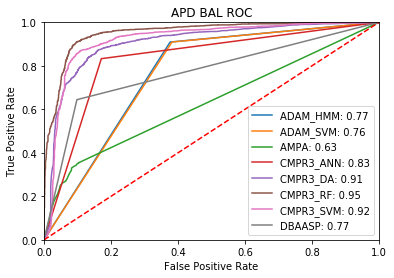

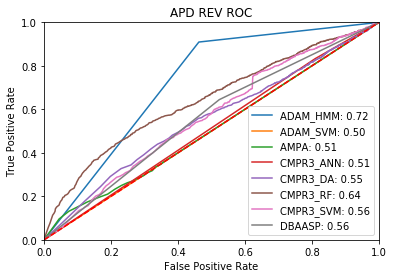

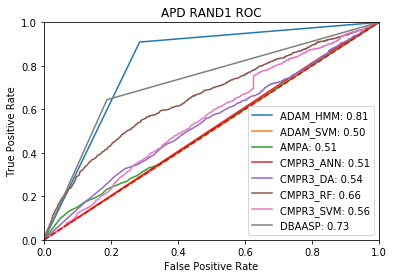

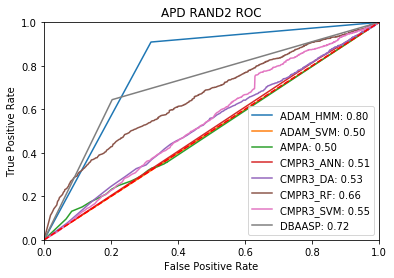

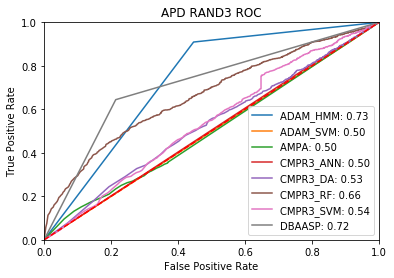

In [13]:
for r in REVERSE:
    plot_roc('APD', 'A', r)

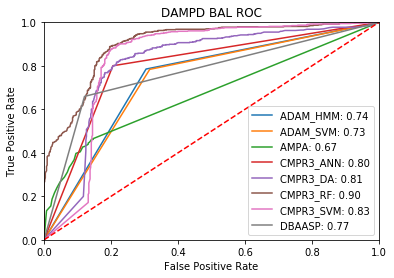

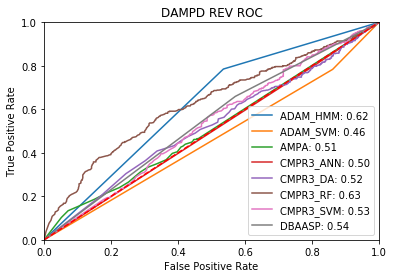

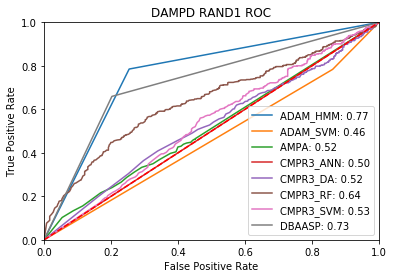

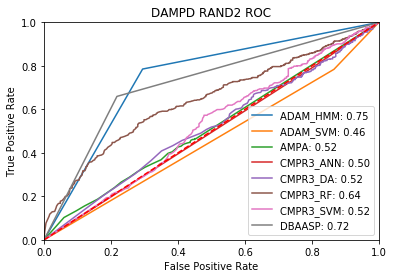

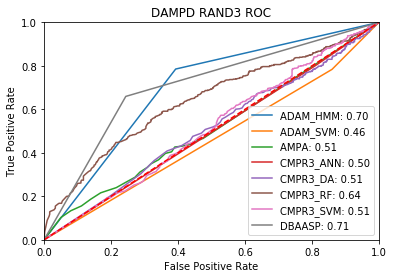

In [14]:
for r in REVERSE:
    plot_roc('DAMPD', 'D', r)